In [1]:
import tempfile
import os
import argparse
import csv 
import numpy as np
import math
import random
import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models

from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from utils import stats_report, save_model, loaf_tf_lite_model
from cosine_annealing import CosineAnnealingScheduler
from swa.tfkeras import SWA

In [2]:
def loadCSV(csvf):
    """
    return a dict saving the information of csv
    :param splitFile: csv file name
    :return: {label:[file1, file2 ...]}
    """
    dictLabels = {}
    with open(csvf) as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        next(csvreader, None)  # skip (filename, label)
        for i, row in enumerate(csvreader):
            filename = row[0]
            label = row[1]

            # append filename to current label
            if label in dictLabels.keys():
                dictLabels[label].append(filename)
            else:
                dictLabels[label] = [filename]
    return dictLabels

In [3]:
def txt_to_numpy(filename, row):
    file = open(filename)
    lines = file.readlines()
    datamat = np.arange(row, dtype=np.float64)
    row_count = 0
    for line in lines:
        line = line.strip().split(' ')
        datamat[row_count] = line[0]
        row_count += 1

    return datamat

In [4]:
# Define dataset
class IEGM_DataSET():
    def __init__(self, root_dir, indice_dir, mode, size, transform=None):
        self.root_dir = root_dir
        self.indice_dir = indice_dir
        self.size = size
        self.names_list = []
        self.transform = transform

        csvdata_all = loadCSV(os.path.join(self.indice_dir, mode + '_indice.csv'))

        for i, (k, v) in enumerate(csvdata_all.items()):
            self.names_list.append(str(k) + ' ' + str(v[0]))

    def __len__(self):
        return len(self.names_list)

    def __getitem__(self, idx):
        text_path = self.root_dir + self.names_list[idx].split(' ')[0]

        if not os.path.isfile(text_path):
            print(text_path + 'does not exist')
            return None

        IEGM_seg = txt_to_numpy(text_path, self.size).reshape(1, self.size, 1)
        label = int(self.names_list[idx].split(' ')[1])
        sample = {'IEGM_seg': IEGM_seg, 'label': label}

        return sample



In [5]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, root_dir, indice_dir, mode, size):
        self.root_dir = root_dir
        self.indice_dir = indice_dir
        self.size = size
        self.names_list = []

        csvdata_all = loadCSV(os.path.join(self.indice_dir, mode + '_indice.csv'))

        for i, (k, v) in enumerate(csvdata_all.items()):
            self.names_list.append(str(k) + ' ' + str(v[0]))

  def __len__(self):
    return len(self.names_list)

  def __getitem__(self, idx):
    text_path = self.root_dir + self.names_list[idx].split(' ')[0]
    if not os.path.isfile(text_path):
      print(text_path + 'does not exist')
      return None

    IEGM_seg = txt_to_numpy(text_path, self.size).reshape(1, self.size, 1)
    label = int(self.names_list[idx].split(' ')[1])
    # sample = np.array(IEGM_seg, label)
    sample = np.append(IEGM_seg, label)
    # sample = {'IEGM_seg': IEGM_seg, 'label': label}
    return sample

In [6]:
# Define the model architecture.

def model_best():
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(1250, 1)),
      tf.keras.layers.Conv1D(filters=3, kernel_size=85, strides=32, padding='valid', activation=None, use_bias=True),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ReLU(),
      tf.keras.layers.Flatten(),

      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(20),
      tf.keras.layers.ReLU(),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(10),
      tf.keras.layers.ReLU(),
      tf.keras.layers.Dense(2),
  ])
  return model

In [8]:
#THIS CELL IS NOT REQUIRED
# Example usage:
# Replace 'your_ecg_data' with your actual training ECG data
# Replace 'your_dl_network' with your actual deep learning network
# Set the desired target_ratio
# lth_pruning(your_ecg_data, your_dl_network, pruning_percent=30, target_ratio=0.2)

def get_model():
    argparser = argparse.ArgumentParser()
    argparser.add_argument('--epoch', type=int, help='epoch number', default=100)
    argparser.add_argument('--lr', type=float, help='learning rate', default=0.0002)
    argparser.add_argument('--batchsz', type=int, help='total batchsz for traindb', default=4)
    argparser.add_argument('--cuda', type=int, default=0)
    argparser.add_argument('--size', type=int, default=1250)
    argparser.add_argument('--path_data', type=str, default='/Users/mousumi/LTH_ModelCompression/model-compression-technique-for-on-device-learning/Training/tinyml_contest_data_training/')
    argparser.add_argument('--path_indices', type=str, default='/Users/mousumi/LTH_ModelCompression/model-compression-technique-for-on-device-learning/Training/data_indices')
    
    args = argparser.parse_args()

    # Hyperparameters
    BATCH_SIZE = args.batchsz
    BATCH_SIZE_TEST = args.batchsz
    LR = args.lr
    EPOCH =  20 #args.epoch
    SIZE = args.size
    path_data = args.path_data
    path_indices = args.path_indices
    # Data aug setting
    data_aug = True
    mix = False
    flip_peak = True
    flip_time = False
    add_noise = True

    train_generator = DataGenerator(root_dir=path_data, indice_dir=path_indices, mode='train', size=SIZE)
    train_dataset = tf.data.Dataset.from_tensor_slices(train_generator)
    train_dataset = train_dataset.shuffle(10).batch(len(train_generator))
    train_dataset = train_dataset.repeat()
    train_iterator = iter(train_dataset)

    test_generator = DataGenerator(root_dir=path_data, indice_dir=path_indices, mode='test', size=SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices(test_generator)
    test_dataset = test_dataset.shuffle(10).batch(len(test_generator))
    test_dataset = test_dataset.repeat()
    test_iterator = iter(test_dataset)

    one_element = train_iterator.get_next()
    x, y = one_element[...,0:-1], one_element[...,-1]
    x = np.expand_dims(x, axis=2)

    test_samples = test_iterator.get_next()
    x_test, y_test = test_samples[...,0:-1], test_samples[...,-1]
    x_test = np.expand_dims(x_test, axis=2)
    
    if data_aug:
      if mix:
        x_aug, y_aug = np.concatenate((x, x_test), axis=0), np.concatenate((y, y_test), axis=0)
        print('Mix Data Finish!')    
      else:
        x_aug = np.copy(x)
        y_aug = np.copy(y)
        for i in range(len(x)):
          flip_p = random.random()
          flip_t = random.random()
          if flip_p < 0.5 and flip_peak:
            x_aug[i] = -x[i]
          if flip_t < 0.5 and flip_time:
            x_aug[i] = np.flip(x[i])
          if add_noise:
            max_peak = x_aug[i].max() * 0.05
            factor = random.random()
            # factor = 1
            noise = np.random.normal(0, factor * max_peak, (len(x_aug[i]), 1))
            x_aug[i] = x_aug[i] + noise

        print('flip Peak: ', flip_peak)
        print('Add Noise: ', add_noise) 
    
    start_epoch = 10
    swa = SWA(start_epoch=start_epoch, 
          lr_schedule='cyclic', 
          swa_lr=0.0001,
          swa_lr2=0.0005,
          swa_freq=5,
          batch_size=args.batchsz,
          verbose=1)

    my_model = model_best()
    save_name = 'random_' + 'lth'
    # save_name = 'SWA' 
    checkpoint_filepath = './20_10/' + save_name + '/weights.{epoch:02d}-{val_loss:.2f}.weights.h5'

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',  # You can specify the metric you want to monitor
        mode='max',
        save_best_only=True  # Optionally save only the best weights
    )



    # my_model = model_best()
    # save_name = 'random_' + 'lth'
    # # save_name = 'SWA' 
    # checkpoint_filepath = './20_10/' + save_name + '/'
    # model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    #     filepath=checkpoint_filepath,
    #     save_weights_only=True,
    #     monitor='val_accuracy',
    #     mode='max',
    #     save_best_only=True)

    # Train the digit classification model
    # lrate = LearningRateScheduler(step_decay)
    lrate = CosineAnnealingScheduler(T_max=100, eta_max=4e-4, eta_min=2e-4)

    return my_model, x_aug, y_aug, args, model_checkpoint_callback, x_test, y_test
    #return print(type(train_dataset))

In [7]:
def prune_model(model, pruning_percent):
    # Flatten and sort weights
    weights = []
    for layer in model.layers:
        if isinstance(layer, layers.Conv1D) or isinstance(layer, layers.Dense):
            weights.extend(tf.reshape(layer.get_weights()[0], [-1]))
    weights = tf.sort(tf.abs(weights))

    # Calculate threshold for pruning
    threshold_idx = int(pruning_percent * len(weights))
    threshold = weights[threshold_idx]

    # Prune weights below the threshold
    for layer in model.layers:
        if isinstance(layer, layers.Conv1D) or isinstance(layer, layers.Dense):
            weights = layer.get_weights()
            weights[0][tf.abs(weights[0]) < threshold] = 0
            layer.set_weights(weights)

    return model

In [8]:
def calculate_nonzero_params_ratio(model):
    total_params = 0
    nonzero_params = 0

    for layer in model.layers:
        if isinstance(layer, layers.Conv1D) or isinstance(layer, layers.Dense):
            total_params += tf.size(layer.get_weights()[0])
            nonzero_params += tf.math.count_nonzero(layer.get_weights()[0])

    return float(nonzero_params) / float(total_params)

In [9]:
def step_decay(step):
  initial_learning_rate = 0.0004
  decay_steps = 100
  alpha = 0.0001
  step = min(step, decay_steps)
  cosine_decay = 0.5 * (1 + math.cos(math.pi * step / decay_steps))
  decayed = (1 - alpha) * cosine_decay + alpha
  return initial_learning_rate * decayed

In [12]:
# def lth_pruning(pruning_percent, target_ratio):
#     # Step 2: Randomly initialize the given DL network
#     # model, x_aug, y_aug, args, model_checkpoint_callback, x_test, y_test = get_model()

#     ##instead of call the function get_model, replace with the equivalent data

#     model, x_aug, y_aug, args, model_checkpoint_callback, x_test, y_test = get_model()


#     while True:
#         # Step 3: Train the DL network with the given data
#         model.compile(
#            optimizer=Adam(learning_rate=args.lr),
#                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                     metrics=['accuracy']
# )
#      # You may need to adjust the optimizer and loss based on your task
        
#         model.fit(
#                 x_aug,
#                 y_aug,
#                 epochs=2,
#                 batch_size=args.batchsz,
#                 validation_split=0.3,
#                 shuffle=True,
#                 # validation_data=(x_test, y_test),
#                 callbacks=[model_checkpoint_callback]
#             )
#         # Step 4: Prune pruning_percent% of weights with least magnitude
#         model = prune_model(model, pruning_percent)

#         # Step 5: Check the remaining ratio of weights
#         current_ratio = calculate_nonzero_params_ratio(model)
#         print(f"Remaining ratio: {current_ratio}")
        
#         # Step 5: if current_ratio >= target_ratio, STOP and output the pruned model
#         if current_ratio >= target_ratio:
#             print("Pruning complete.")

#             pred = model.predict(x_test).argmax(axis=1)
#             segs_TP = 0
#             segs_TN = 0
#             segs_FP = 0
#             segs_FN = 0

#             for predicted_test, labels_test in zip(pred, y_test.numpy()):
#                 if labels_test == 0:
#                     segs_FP += (1 - (predicted_test == labels_test).sum()).item()
#                     segs_TN += (predicted_test == labels_test).sum().item()
#                 elif labels_test == 1:
#                     segs_FN += (1 - (predicted_test == labels_test).sum()).item()
#                     segs_TP += (predicted_test == labels_test).sum().item()
#             FB = stats_report([segs_TP, segs_FN, segs_FP, segs_TN])

#             return FB, model

#         # Step 6: Adjust pruning_percent
#         pruning_percent *= 1.1

#         # Step 7: Reset the model
#         model.set_weights(model.get_weights())

In [11]:
import argparse
import sys

if 'ipykernel_launcher' in sys.argv[0]:
    # Running in Jupyter, manually define default arguments
    class Args:
        epoch = 100
        lr = 0.0002
        batchsz = 4
        cuda = 0
        size = 1250
        path_data = '/Users/mousumi/LTH_ModelCompression/model-compression-technique-for-on-device-learning/Training/tinyml_contest_data_training/'
        path_indices = '/Users/mousumi/LTH_ModelCompression/model-compression-technique-for-on-device-learning/Training/data_indices'
    args = Args()
else:
    # When running from the command line, use argparse to parse the arguments
    argparser = argparse.ArgumentParser()
    argparser.add_argument('--epoch', type=int, help='epoch number', default=100)
    argparser.add_argument('--lr', type=float, help='learning rate', default=0.0002)
    argparser.add_argument('--batchsz', type=int, help='total batch size for training', default=4)
    argparser.add_argument('--cuda', type=int, default=0)
    argparser.add_argument('--size', type=int, default=1250)
    argparser.add_argument('--path_data', type=str, default='/Users/mousumi/LTH_ModelCompression/model-compression-technique-for-on-device-learning/Training/tinyml_contest_data_training/')
    argparser.add_argument('--path_indices', type=str, default='/Users/mousumi/LTH_ModelCompression/model-compression-technique-for-on-device-learning/Training/data_indices')
    
    args = argparser.parse_args()

# Use args as normal from this point onward
BATCH_SIZE = args.batchsz
BATCH_SIZE_TEST = args.batchsz
LR = args.lr
EPOCH =  20  # args.epoch
SIZE = args.size
path_data = args.path_data
path_indices = args.path_indices

# Data augmentation settings
data_aug = True
mix = False
flip_peak = True
flip_time = False
add_noise = True

# The rest of your code remains unchanged
train_generator = DataGenerator(root_dir=path_data, indice_dir=path_indices, mode='train', size=SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices(train_generator)
train_dataset = train_dataset.shuffle(10).batch(len(train_generator))
train_dataset = train_dataset.repeat()
train_iterator = iter(train_dataset)

test_generator = DataGenerator(root_dir=path_data, indice_dir=path_indices, mode='test', size=SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_generator)
test_dataset = test_dataset.shuffle(10).batch(len(test_generator))
test_dataset = test_dataset.repeat()
test_iterator = iter(test_dataset)

one_element = train_iterator.get_next()
x, y = one_element[..., 0:-1], one_element[..., -1]
x = np.expand_dims(x, axis=2)

test_samples = test_iterator.get_next()
x_test, y_test = test_samples[..., 0:-1], test_samples[..., -1]
x_test = np.expand_dims(x_test, axis=2)

if data_aug:
    if mix:
        x_aug, y_aug = np.concatenate((x, x_test), axis=0), np.concatenate((y, y_test), axis=0)
        print('Mix Data Finish!')
    else:
        x_aug = np.copy(x)
        y_aug = np.copy(y)
        for i in range(len(x)):
            flip_p = random.random()
            flip_t = random.random()
            if flip_p < 0.5 and flip_peak:
                x_aug[i] = -x[i]
            if flip_t < 0.5 and flip_time:
                x_aug[i] = np.flip(x[i])
            if add_noise:
                max_peak = x_aug[i].max() * 0.05
                factor = random.random()
                noise = np.random.normal(0, factor * max_peak, (len(x_aug[i]), 1))
                x_aug[i] = x_aug[i] + noise

        print('flip Peak:', flip_peak)
        print('Add Noise:', add_noise)

start_epoch = 10
swa = SWA(start_epoch=start_epoch, 
          lr_schedule='cyclic', 
          swa_lr=0.0001,
          swa_lr2=0.0005,
          swa_freq=5,
          batch_size=args.batchsz,
          verbose=1)

my_model = model_best()
save_name = 'random_' + 'lth'
checkpoint_filepath = './20_10/' + save_name + '/weights.{epoch:02d}-{val_loss:.2f}.weights.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)
lrate = CosineAnnealingScheduler(T_max=100, eta_max=4e-4, eta_min=2e-4)

# # Ensure the model is compiled before training
# my_model.compile(optimizer='adam',
#                  loss='sparse_categorical_crossentropy',  # Use this loss if your labels are integers
#                  metrics=['accuracy'])

# # Define the learning rate scheduler
# lrate = CosineAnnealingScheduler(T_max=100, eta_max=4e-4, eta_min=2e-4)

# # Define the list of callbacks (including the learning rate scheduler and checkpoint)
# callbacks = [model_checkpoint_callback, lrate]

# # Fit the model with the callbacks
# history = my_model.fit(
#     x_aug, y_aug, 
#     epochs=args.epoch, 
#     batch_size=args.batchsz, 
#     validation_data=(x_test, y_test), 
#     callbacks=callbacks  # Add the learning rate scheduler here
# )
#

# Print all relevant variables
# print("Train Dataset:", train_dataset)
# print("Test Dataset:", test_dataset)
# print("Model:", my_model)
# print("Augmented Training Data (x_aug):", x_aug[:1])  
# print("Augmented Training Labels (y_aug):", y_aug[:1])
# print("Shape of x_aug", len(x_aug))
# print("Shape of x_aug[1]", len(x_aug[1]))
# print("Shape of y_aug",y_aug.__len__())
# print("Arguments (args):", args)
# print("Model Checkpoint Callback:", model_checkpoint_callback)
# print("Test Data (x_test):", x_test[:1])
# print("Shape of x_test",len(x_test))
# print("Test Labels (y_test):", y_test[:1])
# print("Shape of y_test",len(y_test))



flip Peak: True
Add Noise: True


In [ ]:
args

In [12]:
#before prune test
num_features = x_aug.shape[1]  # Assuming x_aug.shape[1] gives the number of features per sample
num_classes = len(np.unique(y_aug))  # Assuming y_aug contains integer labels

model = model_best() # (num_features=num_features, num_classes=num_classes)
num_features=num_features 
num_classes=num_classes

# Prepare for training
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use this loss if your labels are integers
              metrics=['accuracy'])

# Assuming x_aug and x_test are numpy arrays and need reshaping if they're not the right shape already
# They should be shaped as (num_samples, num_features) for Dense layers to work properly
x_aug = x_aug.reshape(-1, num_features)  # Reshape if necessary
x_test = x_test.reshape(-1, num_features)  # Reshape if necessary

lrate = CosineAnnealingScheduler(T_max=100, eta_max=4e-4, eta_min=2e-4)

# Define the list of callbacks (including the learning rate scheduler and checkpoint)
callbacks = [model_checkpoint_callback, lrate]

# Fit the model
history=model.fit(x_aug, y_aug, epochs=25, batch_size=4, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/25


2024-10-01 07:59:42.464754: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


6147/6147 [==============================] - 4s 602us/step - loss: 0.7325 - accuracy: 0.5203 - val_loss: 0.5845 - val_accuracy: 0.5753 - lr: 4.0000e-04
Epoch 2/25
6147/6147 [==============================] - 4s 581us/step - loss: 0.6600 - accuracy: 0.5185 - val_loss: 0.5520 - val_accuracy: 0.5753 - lr: 3.9995e-04
Epoch 3/25
6147/6147 [==============================] - 4s 585us/step - loss: 0.6336 - accuracy: 0.5186 - val_loss: 0.5286 - val_accuracy: 0.5753 - lr: 3.9980e-04
Epoch 4/25
6147/6147 [==============================] - 4s 578us/step - loss: 0.6091 - accuracy: 0.5266 - val_loss: 0.5064 - val_accuracy: 0.6212 - lr: 3.9956e-04
Epoch 5/25
6147/6147 [==============================] - 4s 586us/step - loss: 0.5806 - accuracy: 0.6981 - val_loss: 0.3589 - val_accuracy: 0.8823 - lr: 3.9921e-04
Epoch 6/25
6147/6147 [==============================] - 4s 592us/step - loss: 0.4932 - accuracy: 0.7823 - val_loss: 0.3296 - val_accuracy: 0.9019 - lr: 3.9877e-04
Epoch 7/25
6147/6147 [===========

In [16]:
#metrics before pruning
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Get predicted probabilities for the positive class (for AUC-ROC)
y_pred_prob = model.predict(x_test)

# If softmax activation (shape = (num_samples, 2)), extract the second column
if y_pred_prob.shape[1] == 2:
    y_pred_prob = y_pred_prob[:, 1]  # Take the probability of the positive class

# Get predicted classes (threshold at 0.5 for binary classification)
y_pred_class = (y_pred_prob >= 0.5).astype(int)

# Metrics Calculation
# Precision
precision = precision_score(y_test, y_pred_class)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred_class)
print(f"Recall: {recall:.4f}")

# F1-Score
f1 = f1_score(y_test, y_pred_class)
print(f"F1 Score: {f1:.4f}")

# AUC-ROC Score
auc_roc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC-ROC: {auc_roc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:")
print(cm)

# # Plot Confusion Matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# Detailed Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

176/176 [==============================] - 0s 568us/step
Precision: 0.8369
Recall: 0.7581
F1 Score: 0.7955
AUC-ROC: 0.8983
Confusion Matrix:
[[2883  353]
 [ 578 1811]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      3236
         1.0       0.84      0.76      0.80      2389

    accuracy                           0.83      5625
   macro avg       0.83      0.82      0.83      5625
weighted avg       0.83      0.83      0.83      5625



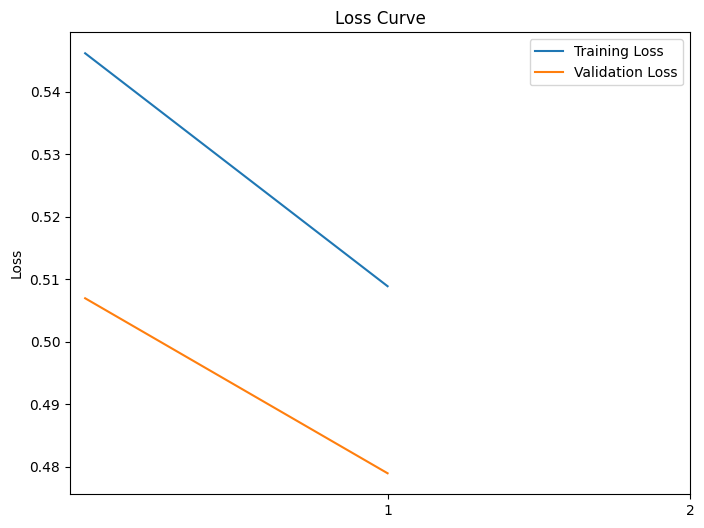

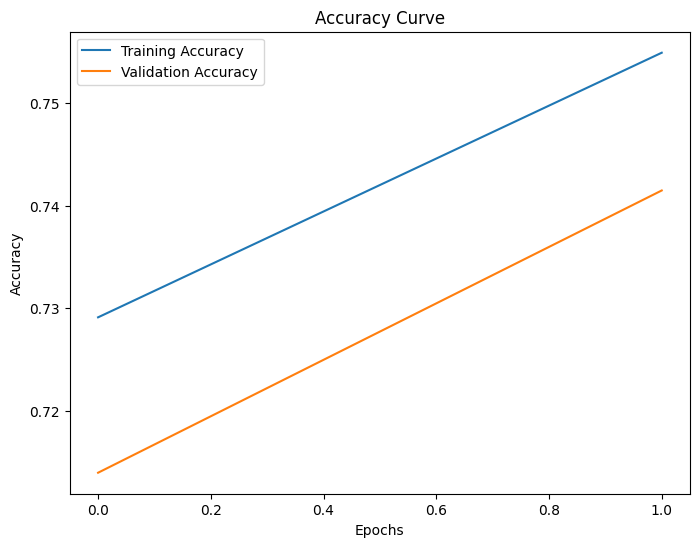

176/176 [==============================] - 0s 425us/step


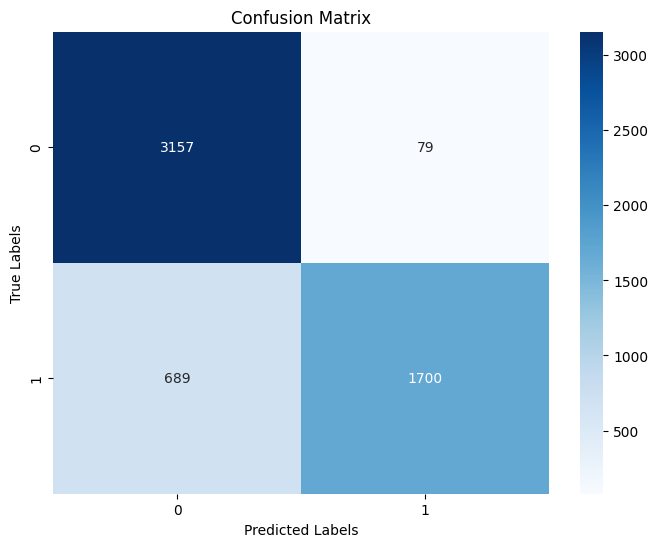

176/176 [==============================] - 0s 418us/step


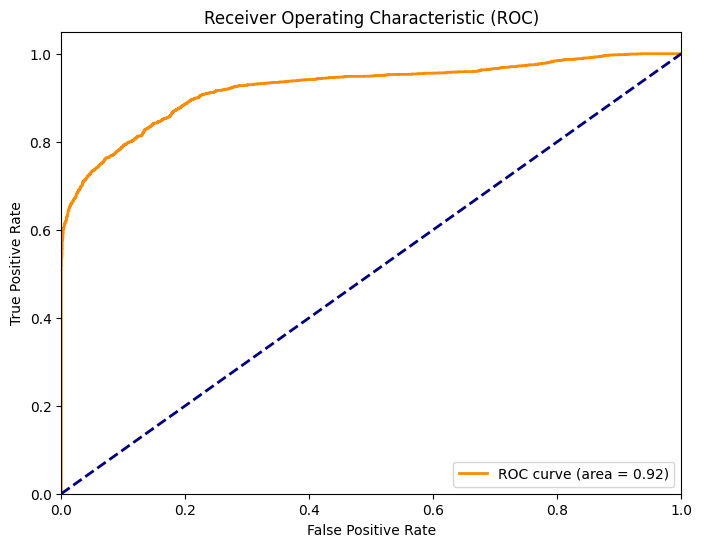

In [22]:
#PLOTS BEFORE PRUNING 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Plot the training and validation loss curves
def plot_loss_curves(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    # plt.xlabel('Epochs')
    epochs = range(1, len(history.history['loss']) + 1)
    plt.xticks(epochs) 
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot the training and validation accuracy curves
def plot_accuracy_curves(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the confusion matrix
def plot_confusion_matrix(model, x_test, y_test):
    y_pred = model.predict(x_test).argmax(axis=1)  # Get the predicted labels
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Plot the ROC-AUC curve
def plot_roc_auc_curve(model, x_test, y_test):
    y_pred_prob = model.predict(x_test)  # Get predicted probabilities

    # If the model uses softmax activation for binary classification, get probabilities for class 1
    if y_pred_prob.shape[1] == 2:
        y_pred_prob = y_pred_prob[:, 1]

    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Call the functions to plot all the graphs
plot_loss_curves(history)
plot_accuracy_curves(history)
plot_confusion_matrix(model, x_test, y_test)
plot_roc_auc_curve(model, x_test, y_test)


In [18]:
#LTH PRUNING

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# lth_pruning(0.3, .2)
# def lth_pruning(pruning_percent, target_ratio):
    # Step 2: Randomly initialize the given DL network
    # model, x_aug, y_aug, args, model_checkpoint_callback, x_test, y_test = get_model()

    ##instead of call the function get_model, replace with the equivalent data

model, x_aug, y_aug, args, model_checkpoint_callback, x_test, y_test = my_model, x_aug, y_aug, args, model_checkpoint_callback, x_test, y_test

pruning_percent=0.3
target_ratio=.2
history_list = []  # To store loss values

while True:
    # Step 3: Train the DL network with the given data
    model.compile(
        optimizer=Adam(learning_rate=args.lr),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy']
)
    # You may need to adjust the optimizer and loss based on your task
    
    history=model.fit(
            x_aug,
            y_aug,
            epochs=2,
            batch_size=args.batchsz,
            validation_split=0.3,
            shuffle=True,
            # validation_data=(x_test, y_test),
            callbacks=[model_checkpoint_callback]
        )
    
    # Append loss values to history_list
    history_list.append(history)

    # Step 4: Prune pruning_percent% of weights with least magnitude
    model = prune_model(model, pruning_percent)

    # Step 5: Check the remaining ratio of weights
    current_ratio = calculate_nonzero_params_ratio(model)
    print(f"Remaining ratio: {current_ratio}")
    
    # Step 5: if current_ratio >= target_ratio, STOP and output the pruned model
    if current_ratio >= target_ratio:
        print("Pruning complete.")

        pred = model.predict(x_test).argmax(axis=1)
        segs_TP = 0
        segs_TN = 0
        segs_FP = 0
        segs_FN = 0

        for predicted_test, labels_test in zip(pred, y_test.numpy()):
            if labels_test == 0:
                segs_FP += (1 - (predicted_test == labels_test).sum()).item()
                segs_TN += (predicted_test == labels_test).sum().item()
            elif labels_test == 1:
                segs_FN += (1 - (predicted_test == labels_test).sum()).item()
                segs_TP += (predicted_test == labels_test).sum().item()
        FB = stats_report([segs_TP, segs_FN, segs_FP, segs_TN])

        #return FB, model
        print(FB)
        print(model)

        # cm = confusion_matrix(y_test, pred)
        
        # # Plot the confusion matrix
        # plt.figure(figsize=(8, 6))
        # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
        # plt.title("Confusion Matrix")
        # plt.xlabel("Predicted")
        # plt.ylabel("True")
        # plt.show()

        # # Plot loss curve
        # train_loss = np.concatenate([h.history['loss'] for h in history_list])
        # val_loss = np.concatenate([h.history['val_loss'] for h in history_list])

        # plt.figure(figsize=(8, 6))
        # plt.plot(train_loss, label='Training Loss')
        # plt.plot(val_loss, label='Validation Loss')
        # plt.title("Loss Curve")
        # plt.xlabel("Epochs")
        # plt.ylabel("Loss")
        # plt.legend()
        # plt.show()

        # Print the stats
        # print(stats_report([segs_TP, segs_FN, segs_FP, segs_TN]))
        break

    # Step 6: Adjust pruning_percent
    pruning_percent *= 1.1

    # Step 7: Reset the model
    model.set_weights(model.get_weights())

Epoch 1/2
4303/4303 [==============================] - 3s 754us/step - loss: 0.5461 - accuracy: 0.7291 - val_loss: 0.5069 - val_accuracy: 0.7140
Epoch 2/2
4303/4303 [==============================] - 3s 645us/step - loss: 0.5088 - accuracy: 0.7549 - val_loss: 0.4789 - val_accuracy: 0.7415
Remaining ratio: 0.7001855287569573
Pruning complete.
176/176 [==============================] - 0s 362us/step
F-1 =  0.8157389635316697
F-B =  0.7498897220996912
SEN =  0.7115948095437421
SPE =  0.9755871446229913
BAC =  0.8435909770833667
ACC =  0.8634666666666667
PPV =  0.955593029792018
NPV =  0.8208528341133645
0.7498897220996912


In [19]:
#METRICS AFTER LTH PRUNING
#600 dpi image

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Assuming y_test and pred are the true and predicted labels

# Precision
precision = precision_score(y_test, pred, average='weighted')  # Can also use 'micro', 'macro', or 'binary'
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, pred, average='weighted')
print(f"Recall: {recall:.4f}")

# F1-Score
f1 = f1_score(y_test, pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# AUC-ROC (for binary classification)
# For binary classification, the model's predict function will return probabilities
# So, we take the probability of the positive class (class 1)
y_pred_prob = model.predict(x_test)  # This gives probabilities for each class

# If the shape of y_pred_prob is (num_samples, 1) or (num_samples,), no slicing is needed
if y_pred_prob.shape[1] == 2:  # In case it's a binary classification problem and two outputs
    y_pred_prob = y_pred_prob[:, 1]  # Probability for the positive class (class 1)

auc_roc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC-ROC: {auc_roc:.4f}")


Precision: 0.8781
Recall: 0.8635
F1 Score: 0.8594
176/176 [==============================] - 0s 355us/step
AUC-ROC: 0.9227


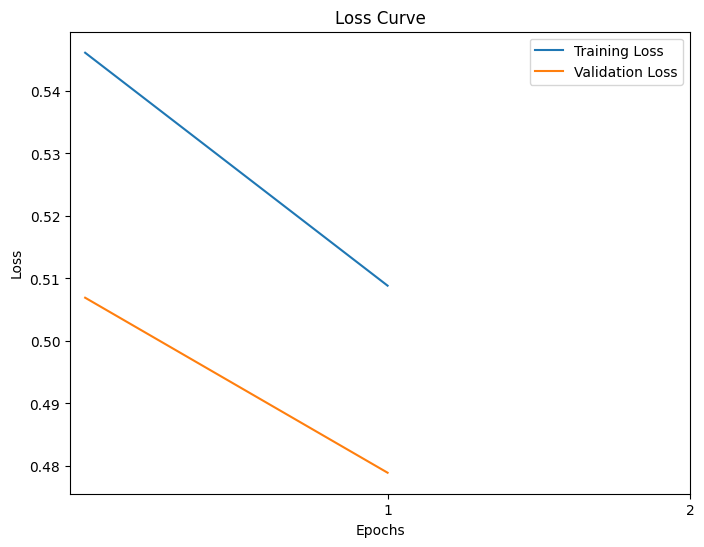

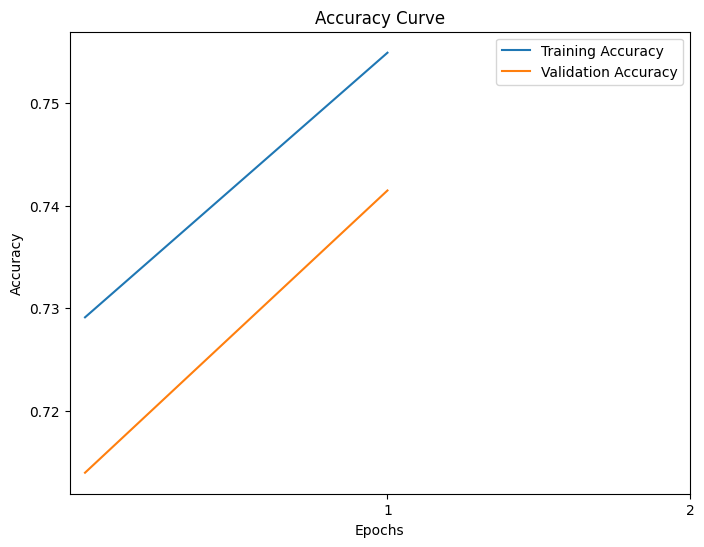

176/176 [==============================] - 0s 408us/step


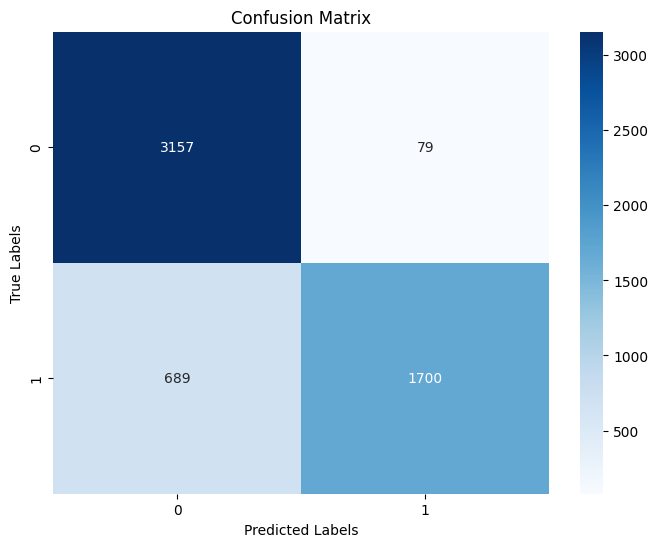

176/176 [==============================] - 0s 387us/step


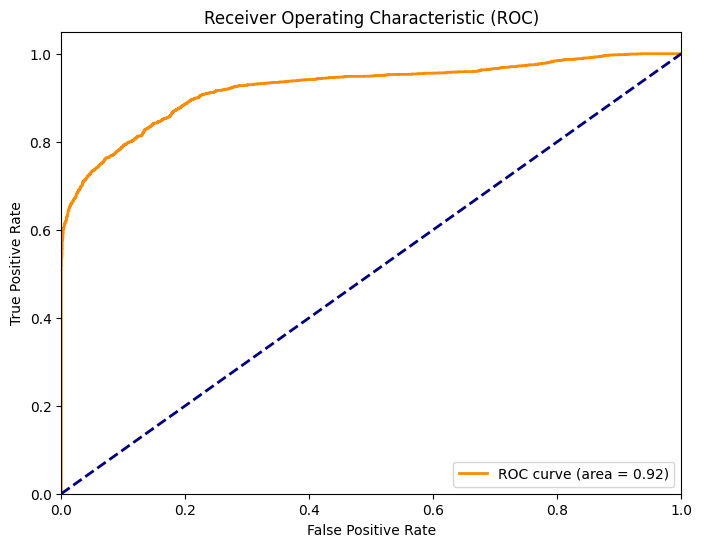

In [21]:
#GRAPHS AFTER LTH PRUNING

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Plot the training and validation loss curves
def plot_loss_curves(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    # Set the x-axis to show whole number epochs
    epochs = range(1, len(history.history['loss']) + 1)
    plt.xticks(epochs)  # Set x-ticks as whole numbers
    plt.legend()
    plt.show()

# Plot the training and validation accuracy curves
def plot_accuracy_curves(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    # Set the x-axis to show whole number epochs
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.xticks(epochs)  # Set x-ticks as whole numbers
    plt.legend()
    plt.show()

# Plot the confusion matrix
def plot_confusion_matrix(model, x_test, y_test):
    y_pred = model.predict(x_test).argmax(axis=1)  # Get the predicted labels
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Plot the ROC-AUC curve
def plot_roc_auc_curve(model, x_test, y_test):
    y_pred_prob = model.predict(x_test)  # Get predicted probabilities

    # If the model uses softmax activation for binary classification, get probabilities for class 1
    if y_pred_prob.shape[1] == 2:
        y_pred_prob = y_pred_prob[:, 1]

    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Call the functions to plot all the graphs
plot_loss_curves(history)
plot_accuracy_curves(history)
plot_confusion_matrix(model, x_test, y_test)
plot_roc_auc_curve(model, x_test, y_test)


In [ ]:
print(type(x_aug))

In [ ]:
x_aug.shape

In [ ]:
print(model)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class NumericalModel(keras.Model):
    def __init__(self, num_features, num_classes, mlp_units=[64, 32], dropout_rate=0.1):
        super(NumericalModel, self).__init__()
        self.dense_layers = [layers.Dense(units, activation='relu') for units in mlp_units]
        self.dropout = layers.Dropout(dropout_rate)
        self.output_layer = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = inputs
        for dense_layer in self.dense_layers:
            x = dense_layer(x)
            x = self.dropout(x)
        return self.output_layer(x)

# Instantiate the model
num_features = x_aug.shape[1]  # Assuming x_aug.shape[1] gives the number of features per sample
num_classes = len(np.unique(y_aug))  # Assuming y_aug contains integer labels

model = NumericalModel(num_features=num_features, num_classes=num_classes)

# Prepare for training
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use this loss if your labels are integers
              metrics=['accuracy'])

# Assuming x_aug and x_test are numpy arrays and need reshaping if they're not the right shape already
# They should be shaped as (num_samples, num_features) for Dense layers to work properly
x_aug = x_aug.reshape(-1, num_features)  # Reshape if necessary
x_test = x_test.reshape(-1, num_features)  # Reshape if necessary

# Fit the model
model.fit(x_aug, y_aug, epochs=10, batch_size=32, validation_data=(x_test, y_test))


In [ ]:
if __name__ == '__main__':
    best_FB = 0.
    FB, model = lth_pruning(0.3, .2)
    save_model(f"best_model.tflite", model)
    print(FB)
    # for i in range(10):
    #     FB, my_model = run_once(i)
    #     if FB > best_FB:
    #         best_FB = FB
    #         save_model(f"best_model.tflite", my_model)
    #         print('Current Best: ', best_FB)
    #     print(FB)
    # print('Current Best: ', best_FB)